In [172]:
import shutil
import sys
import os
import json
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from ultralytics import YOLO
import ultralytics
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import matplotlib.ticker as ticker
import warnings
import random
import seaborn as sns
import csv
import datetime

In [173]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display

import nbimporter

batch_size = 64
nz = 100
noise_std = 0.7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [174]:
def create_name_to_num():
    with open("IP102/ip102_v1.1/name_num_table.txt") as f:
        name_to_num = [] # class data
        for l in f.read().split("\n"):
            v = tuple(l.split())
            if v:
                if str(int(v[1])+1) in num_to_label.keys():
                    v = [v[0],str(int(v[1])+1)] # to fit the format in num_to_label.txt
                    name_to_num.append(v)
    
    return np.array(name_to_num)


name_to_num = create_name_to_num()

In [185]:
original_DA_num_to_label = {23:"corn borer", 52:"blister beetle"} # original num_to_label

DA_label_to_num = {"corn borer":0, "blister beetle":1} # num_to_label for CGAN

def assign_augment_img(name_to_num):
    DA_path_to_num = []
    src_directory = "IP102/ip102_v1.1/images/"
    for name, num in zip(name_to_num[:, 0], name_to_num[:, 1]):
        num = int(num)
        if num in np.array(list(original_DA_num_to_label.keys())):
            DA_path_to_num.append([src_directory + name, DA_label_to_num[original_DA_num_to_label[num]]])

    return np.array(DA_path_to_num)


DA_path_to_num = assign_augment_img(name_to_num)

## Dataset Creation

In [194]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MyImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Open image file
        image = Image.open(img_path).convert("RGB") 
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

#transforms.Pad(padding),
transform = transforms.Compose([
    transforms.Resize((640,640)),
    transforms.ToTensor()
])

image_paths = DA_path_to_num[:, 0]
labels = DA_path_to_num[:, 1]
labels = labels.astype(np.int64)

dataset = MyImageDataset(image_paths, labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

dataset.targets = torch.tensor(labels)

sample_x, sample_y = next(iter(dataloader))
n_classes = len(torch.unique(dataset.targets))
w, h = sample_x.shape[-2:]
image_size = w * h * 3
print("batch shape:", sample_x.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)
print("number of  classes:", n_classes)

batch shape: torch.Size([64, 3, 640, 640])
width: 640
height: 640
image size: 1228800
number of  classes: 2


## Discriminator

In [195]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(image_size + n_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self._eye = torch.eye(n_classes, device=device)

    def forward(self, x, labels):
        labels = self._eye[labels]
        x = x.view(batch_size, -1)
        x = torch.cat([x, labels], dim=1)
        y = self.net(x)
        return y

## Generator

In [196]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._linear(nz, 128),
            self._linear(128, 256),
            self._linear(256, 512),
            nn.Linear(512, image_size),
            nn.Sigmoid()
        )

    def _linear(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(-1, nz)
        y = self.net(x)
        y = y.view(-1, 1, w, h)
        return y

## 条件の埋め込み

In [197]:
eye = torch.eye(n_classes, device=device)
def make_noise(labels):
    labels = eye[labels]
    labels = labels.repeat_interleave(nz // n_classes, dim=-1)
    z = torch.normal(0, noise_std, size=(len(labels), nz), device=device)
    z = z + labels
    return z

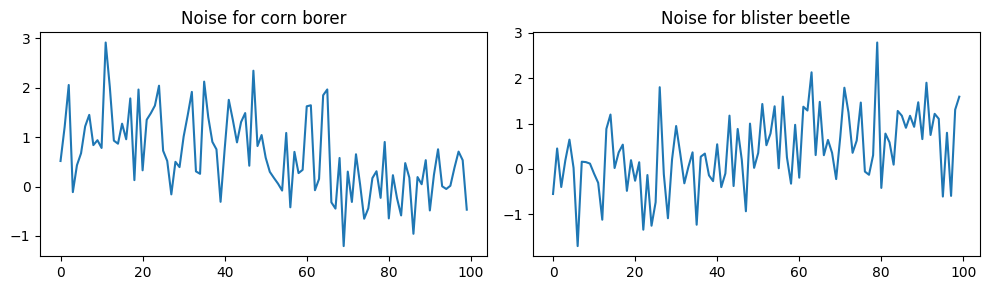

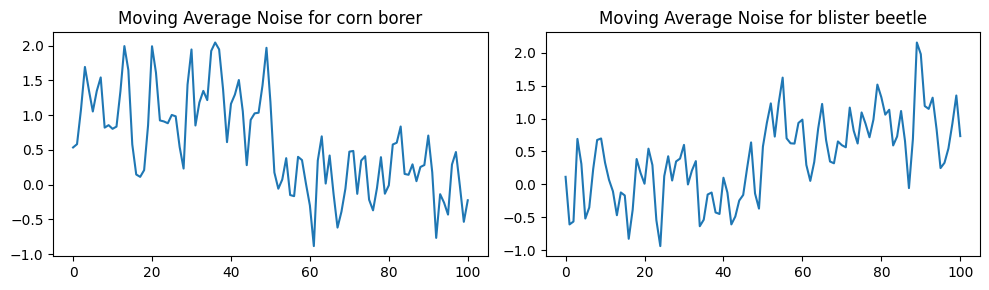

In [198]:
DA_labels = list(augment_pest_class.values())

plt.figure(figsize=(10, 3))

for i in range(2):
    plt.subplot(1, 2, i+1)
    vec = make_noise(torch.tensor([i])).cpu().ravel()
    plt.plot(vec)
    plt.title(f"Noise for {DA_labels[i]}")

plt.tight_layout()

plt.figure(figsize=(10, 3))

for i in range(2):
    plt.subplot(1, 2, i+1)  # specify position: 1 and 2
    vec = make_noise(torch.tensor([i])).cpu().ravel()
    vec = np.convolve(vec, np.ones(n_classes) / n_classes)
    plt.plot(vec)
    plt.title(f"Moving Average Noise for {DA_labels[i]}")

plt.tight_layout()

## training

In [199]:
def write(netG, n_rows=1, size=64):
    n_images = n_rows * n_classes
    z = make_noise(torch.tensor(list(range(n_classes)) * n_rows))
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, n_images // n_rows)
    img = transforms.functional.to_pil_image(img)
    display(img)

def make_false_labels(labels):
    diff = torch.randint(1, n_classes, size=labels.size(), device=device)
    fake_labels = (labels + diff) % n_classes
    return fake_labels

In [200]:
fake_labels = torch.zeros(batch_size, 1).to(device)
real_labels = torch.ones(batch_size, 1).to(device)
criterion = nn.BCELoss()

def train(netD, netG, optimD, optimG, n_epochs, write_interval=1):
    # 学習モード
    netD.train()
    netG.train()

    for epoch in range(1, n_epochs+1):
        for X, labels in dataloader:
            X = X.to(device)
            labels = labels.to(device)
            false_labels = make_false_labels(labels)

            optimD.zero_grad()
            optimG.zero_grad()

            # Discriminatorの学習
            z = make_noise(labels) # ノイズを生成
            fake = netG(z) # 偽物を生成
            pred_fake = netD(fake, labels) # 偽物を判定
            pred_real_true = netD(X, labels) # 本物&正しいラベルを判定
            pred_real_false = netD(X, false_labels) # 本物&間違ったラベルを判定
            loss_fake = criterion(pred_fake, fake_labels)
            loss_real_true = criterion(pred_real_true, real_labels)
            loss_real_false = criterion(pred_real_false, fake_labels)
            lossD = loss_fake + loss_real_true + loss_real_false
            lossD.backward() # 逆伝播
            optimD.step() # パラメータ更新

            # Generatorの学習
            fake = netG(z) # 偽物を生成
            pred = netD(fake, labels) # 偽物を判定
            lossG = criterion(pred, real_labels) # 誤差を計算
            lossG.backward() # 逆伝播
            optimG.step() # パラメータ更新

        print(f'{epoch:>3}epoch | lossD: {lossD:.4f}, lossG: {lossG:.4f}')
        if write_interval and epoch % write_interval == 0:
            write(netG)

初期状態


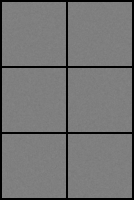

In [ ]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

print('初期状態')
write(netG)
train(netD, netG, optimD, optimG, n_epochs)

In [ ]:
train(netD, netG, optimD, optimG, 30, 5)

学習が完了した。最終的に完成したGeneratorで10個ずつ画像を生成してみる。

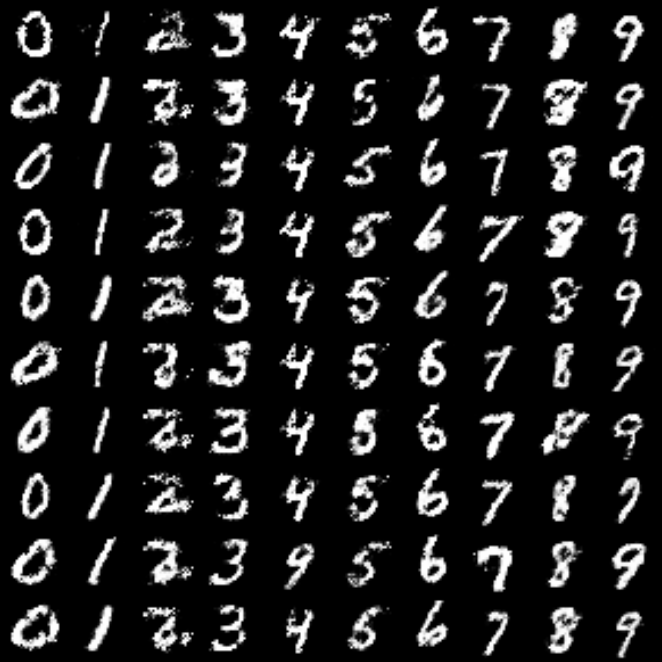

In [19]:
write(netG, 10)

## CDCGAN

### Discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            self._conv_layer(1, 16, 4, 2, 1),
            self._conv_layer(16, 32, 4, 2, 1),
            self._conv_layer(32, 64, 3, 2, 0),
            nn.Conv2d(64, 128, 3, 1, 0),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(128 + n_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self._eye = torch.eye(n_classes, device=device) # 条件ベクトル生成用の単位行列

    def _conv_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x, labels):
        x = self.conv(x) # 特徴抽出
        labels = self._eye[labels] # 条件(ラベル)をone-hotベクトルに
        x = torch.cat([x, labels], dim=1) # 画像と条件を結合
        y = self.fc(x)
        return y

### Generator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._convT(nz, 128, 3, 1, 0),
            self._convT(128, 64, 3, 2, 0),
            self._convT(64, 32, 4, 2, 1),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def _convT(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.view(-1, nz, 1, 1)
        y = self.net(x)
        return y

### Training

初期状態


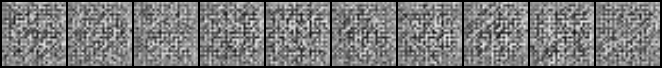

  1epoch | lossD: 1.2048, lossG: 5.6021


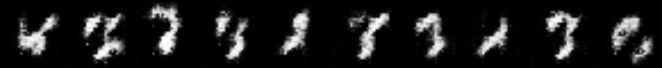

  2epoch | lossD: 0.8368, lossG: 3.7454


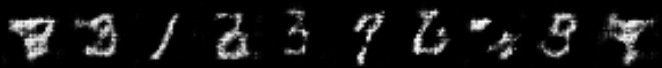

  3epoch | lossD: 0.5882, lossG: 3.7102


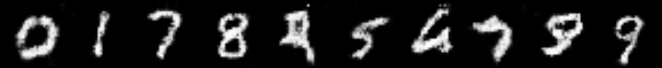

  4epoch | lossD: 0.7658, lossG: 4.3485


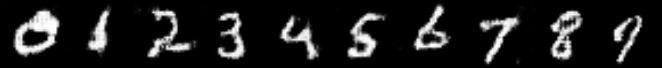

  5epoch | lossD: 0.4928, lossG: 3.2970


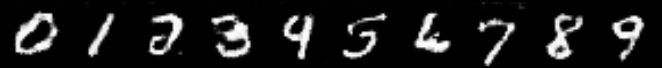

In [11]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

print('初期状態')
write(netG)
train(netD, netG, optimD, optimG, n_epochs)

線が綺麗になっている。追加でもう20epoch学習させてみる。

  1epoch | lossD: 0.5564, lossG: 2.3332
  2epoch | lossD: 0.4464, lossG: 2.5101
  3epoch | lossD: 0.4413, lossG: 3.1200
  4epoch | lossD: 0.9594, lossG: 2.2045
  5epoch | lossD: 0.6172, lossG: 2.0083
  6epoch | lossD: 0.7827, lossG: 2.0454
  7epoch | lossD: 0.7992, lossG: 2.4059
  8epoch | lossD: 0.9733, lossG: 1.9667
  9epoch | lossD: 0.8998, lossG: 2.2014
 10epoch | lossD: 1.2166, lossG: 1.8991


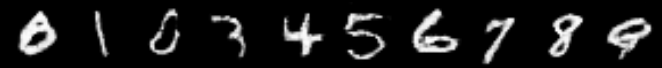

 11epoch | lossD: 1.0778, lossG: 1.3017
 12epoch | lossD: 1.0328, lossG: 1.6238
 13epoch | lossD: 1.1444, lossG: 1.0306
 14epoch | lossD: 0.8188, lossG: 1.5753
 15epoch | lossD: 1.2388, lossG: 1.4567
 16epoch | lossD: 1.2503, lossG: 1.2237
 17epoch | lossD: 0.9939, lossG: 1.6568
 18epoch | lossD: 0.9665, lossG: 1.7362
 19epoch | lossD: 1.1764, lossG: 1.4042
 20epoch | lossD: 1.2774, lossG: 1.4588


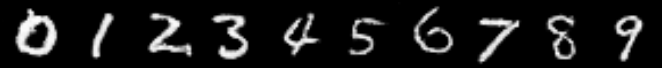

 21epoch | lossD: 1.3268, lossG: 1.1665
 22epoch | lossD: 0.9467, lossG: 1.6162
 23epoch | lossD: 0.9909, lossG: 1.4555
 24epoch | lossD: 0.8155, lossG: 1.6678
 25epoch | lossD: 1.2458, lossG: 1.5919
 26epoch | lossD: 1.0972, lossG: 1.1699
 27epoch | lossD: 0.9935, lossG: 1.2340
 28epoch | lossD: 1.1375, lossG: 1.1097
 29epoch | lossD: 1.2021, lossG: 1.3361
 30epoch | lossD: 0.9146, lossG: 2.5986


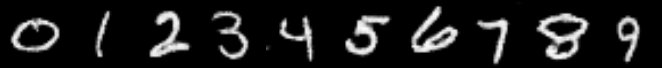

In [12]:
train(netD, netG, optimD, optimG, 30, 10)

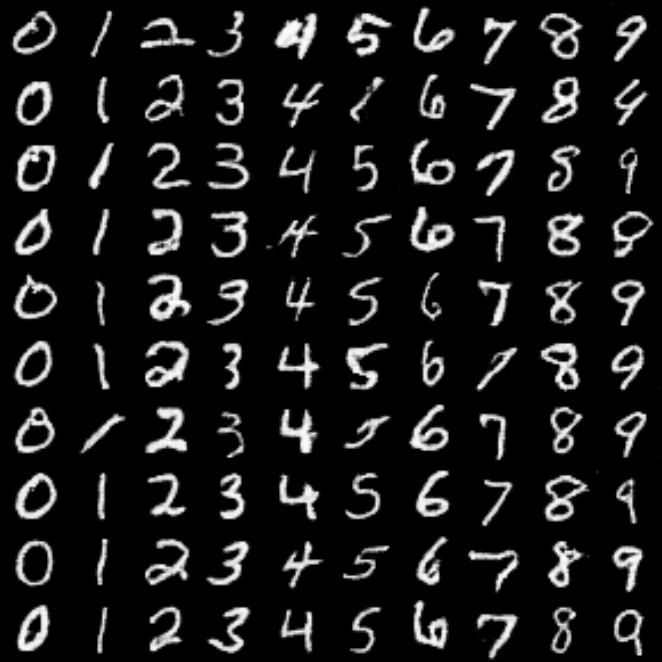

In [13]:
write(netG, 10)

In [69]:
def write_from_label(netG, label, n_images=10, size=64):
    labels = torch.tensor([label]*n_images).to(device)
    labels = labels.repeat_interleave(nz // n_classes, dim=-1)
    z = torch.normal(0, noise_std, size=(len(labels), nz), device=device)
    z = z + labels
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, len(z))
    img = transforms.functional.to_pil_image(img)
    display(img)

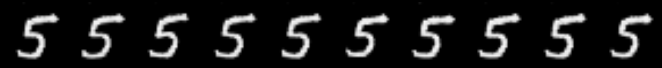

In [70]:
label = [0, 0, 0, 0, 0, 10, 0, 0, 0, 0]
write_from_label(netG, label)

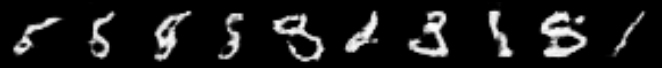

In [71]:
label = [0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0]
write_from_label(netG, label)

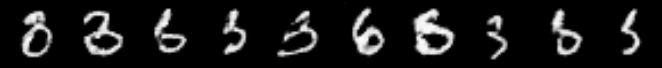

In [72]:
label = [0, 0, 0, 1, 0, 0, 1, 0, 0, 0]
write_from_label(netG, label)

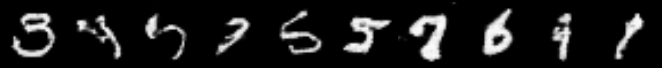

In [73]:
label = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
write_from_label(netG, label)

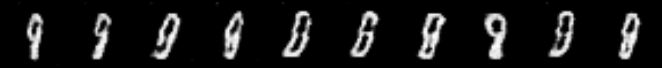

In [75]:
label = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
write_from_label(netG, label)